In [1]:
ENV["LINES"], ENV["COLUMNS"] = 100, 100
#using Base.Threads
#using BenchmarkTools
#using DataFrames
using Distributions
#using LinearAlgebra
#using Memoization
#using Printf
using QuadGK
#using RCall
#using Random
#Random.seed!(4649373)
using Roots
#using SpecialFunctions
#using StaticArrays
using StatsBase
using StatsFuns
using StatsPlots
default(fmt = :png, size = (500, 320),
    titlefontsize = 10, plot_titlefontsize = 12)
#using SymPy

safemul(x, y) = x == 0 ? x : isinf(x) ? typeof(x)(Inf) : x*y
safediv(x, y) = x == 0 ? x : isinf(y) ? zero(y) : x/y

x ⪅ y = x < y || x ≈ y

⪅ (generic function with 1 method)

In [2]:
function pvalue_wilson(n, k, p)
    p̂ = k/n
    SE = √(p*(1-p)/n)
    2ccdf(Normal(), abs(p̂ - p)/SE)
end

function confint_wilson(n, k; α = 0.05)
    p̂ = k/n
    z = quantile(Normal(), 1-α/2)
    a, b, c = 1+z^2/n, p̂+z^2/(2n), p̂^2
    # ap² - 2bp + c = 0 を解く.
    sqrtD = √(b^2 - a*c)
    p_L = (b - sqrtD)/a
    p_U = (b + sqrtD)/a
    [p_L, p_U]
end

confint_wilson (generic function with 1 method)

In [3]:
oddsratiohat(a, b, c, d) = safediv(a*d, b*c)
riskratiohat(a, b, c, d) = safediv(a*(c+d), (a+b)*c)

riskratiohat (generic function with 1 method)

In [4]:
function delta(a, b, c, d; ω=1)
    A, B, C = 1-ω, a+d+ω*(b+c), a*d-ω*b*c
    isinf(ω) ? typeof(ω)(-min(b, c)) : safediv(2C, B + √(B^2 - 4A*C))
end

# correction = 0.5 は連続性補正を与える.
function _chisqstat_or(a, b, c, d, δ; correction=0.0)
    ã, b̃, c̃, d̃ = a-δ, b+δ, c+δ, d-δ
    safemul(max(0, abs(δ)-correction)^2, 1/ã + 1/b̃ + 1/c̃ + 1/d̃)
end

function chisqstat_or(a, b, c, d; ω=1, correction=0.0)
    δ = delta(a, b, c, d; ω)
    _chisqstat_or(a, b, c, d, δ; correction)
end

function pvalue_or_pearson_chisq(a, b, c, d; ω=1, correction=0.0)
    χ² = chisqstat_or(a, b, c, d; ω, correction)
    ccdf(Chisq(1), χ²)
end

function confint_or_pearson_chisq(a, b, c, d; α=0.05, correction=0.0)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logω) = logit(pvalue_or_pearson_chisq(a, b, c, d; ω=exp(logω), correction)) - logit(α)
    ps = if a == 0 || d == 0
        [0, exp(find_zero(f, 0.0))]
    elseif b == 0 || c == 0
        [exp(find_zero(f, 0.0)), Inf]
    else
        ORhat = oddsratiohat(a, b, c, d)
        ω_L, ω_U = ORhat/2, 2ORhat
        [exp(find_zero(f, log(ω_L))), exp(find_zero(f, log(ω_U)))]
    end
end

confint_or_pearson_chisq (generic function with 1 method)

In [5]:
function Delta(a, b, c, d; ρ=1)
    m, n = a+b, c+d
    A, B, C = ρ-1, n-a+ρ*(m-c), a*n-ρ*m*c
    isinf(ρ) ? typeof(ω)(-c) : safediv(2C, B + √(B^2 - 4A*C))
end

function _chisqstat_rr(a, b, c, d, Δ)
    m, n = a+b, c+d
    safemul(Δ^2, safediv(b, m*(a-Δ)) + safediv(d, n*(c+Δ)))
end

function chisqstat_rr(a, b, c, d; ρ=1)
    Δ = Delta(a, b, c, d; ρ)
    _chisqstat_rr(a, b, c, d, Δ)
end

function pvalue_rr_pearson_chisq(a, b, c, d; ρ=1)
    χ² = chisqstat_rr(a, b, c, d; ρ)
    ccdf(Chisq(1), χ²)
end

function confint_rr_pearson_chisq(a, b, c, d; α=0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logρ) = logit(pvalue_rr_pearson_chisq(a, b, c, d; ρ=exp(logρ))) - logit(α)
    RRhat = riskratiohat(a, b, c, d)
    if a == 0
        [0.0, exp(find_zero(f, 0.0))]
    elseif c == 0
        [exp(find_zero(f, 0.0)), Inf]
    elseif b == 0
        [0.0, exp(find_zero(f, log(2RRhat)))]
    elseif d == 0
        [exp(find_zero(f, log(RRhat/2))), Inf]
    else
        ρ_L, ρ_U = RRhat/2, 2RRhat
        [exp(find_zero(f, log(ρ_L))), exp(find_zero(f, log(ρ_U)))]
    end
end

confint_rr_pearson_chisq (generic function with 1 method)

In [6]:
_pdf_le(x, (dist, y)) =  pdf(dist, x) ⪅ y

function _search_boundary(f, x0, Δx, param)
    x = x0
    if f(x, param)
        while f(x - Δx, param) x -= Δx end
    else
        x += Δx
        while !f(x, param) x += Δx end
    end
    x
end

function pvalue_sterne(dist::DiscreteUnivariateDistribution, x)
    Px = pdf(dist, x)
    Px == 0 && return Px
    Px == 1 && return Px
    m = mode(dist)
    Px ≈ pdf(dist, m) && return one(Px)
    if x < m
        y = _search_boundary(_pdf_le, 2m - x, 1, (dist, Px))
        cdf(dist, x) + ccdf(dist, y-1)
    else # x > m
        y = _search_boundary(_pdf_le, 2m - x, -1, (dist, Px))
        cdf(dist, y) + ccdf(dist, x-1)
    end
end

function pvalue_or_sterne(a, b, c, d; ω=1)
    fnch = if ω == 1
        Hypergeometric(a+b, c+d, a+c)
    else
        FisherNoncentralHypergeometric(a+b, c+d, a+c, ω)
    end
    pvalue_sterne(fnch, a)
end

function confint_or_sterne(a, b, c, d; α = 0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logω) = logit(pvalue_or_sterne(a, b, c, d; ω=exp(logω))) - logit(α)
    if a == 0 || d == 0
        [0.0, exp(find_zero(f, 0.0))]
    elseif b == 0 || c == 0
        [exp(find_zero(f, 0.0)), Inf]
    else
        ω_L, ω_U = confint_or_wald(a, b, c, d; α = α/10)
        ps = exp.(find_zeros(f, log(ω_L), log(ω_U)))
        # 次の行は稀に区間にならない場合への対策
        [first(ps), last(ps)]
    end
end

confint_or_sterne (generic function with 1 method)

In [7]:
function pvalue_or_clopper_pearson(a, b, c, d; ω=1)
    fnch = if ω == 1
        Hypergeometric(a+b, c+d, a+c)
    else
        FisherNoncentralHypergeometric(a+b, c+d, a+c, ω)
    end
    min(1, 2cdf(fnch, a), 2ccdf(fnch, a-1))
end

function confint_or_clopper_pearson(a, b, c, d; α = 0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(ω) = logit(pvalue_or_clopper_pearson(a, b, c, d; ω)) - logit(α)
    if a == 0 || d == 0
        [0.0, find_zero(f, 1.0)]
    elseif b == 0 || c == 0
        [find_zero(f, 1.0), Inf]
    else
        ω_L, ω_U = confint_or_wald(a, b, c, d; α = α/10)
        find_zeros(f, ω_L, ω_U)
    end
end

confint_or_clopper_pearson (generic function with 1 method)

In [8]:
function make_pvalue_functions_bayes(a, b, c, d; conjprior=(1, 1), L=10^6)
    beta1 = Beta((conjprior .+ (a, b))...)
    beta2 = Beta((conjprior .+ (c, d))...)
    p = rand(beta1, L)
    q = rand(beta2, L)
    ecdf_or = ecdf(@. p*(1-q)/((1-p)*q))
    ecdf_rr = ecdf(@. p/q)
    pvalue_or_bayes(ω) = min(1, 2ecdf_or(ω), 2(1 - ecdf_or(ω)))
    pvalue_rr_bayes(ρ) = min(1, 2ecdf_rr(ρ), 2(1 - ecdf_rr(ρ)))
    confint_or_bayes(α) = quantile.(Ref(ecdf_or.sorted_values), [α/2, 1-α/2])
    confint_rr_bayes(α) = quantile.(Ref(ecdf_rr.sorted_values), [α/2, 1-α/2])
    (; pvalue_or_bayes, pvalue_rr_bayes, confint_or_bayes, confint_rr_bayes)
end

make_pvalue_functions_bayes (generic function with 1 method)

In [9]:
dump(a)

LoadError: UndefVarError: a not defined

In [10]:
function logtick(; xlim=(0.03, 30))
    xmin, xmax = xlim
    a = floor(Int, log10(xmin))
    b = ceil(Int, log10(xmax))
    logticka = foldl(vcat, (10.0^k*[1, 2, 5] for k in a:-1))
    logticka = logticka[logticka .≥ xmin]
    logtickb = foldl(vcat, (10^k*[1, 2, 5] for k in 0:b))
    logtickb= logtickb[logtickb .≤ xmax]
    logtick = vcat(logticka, logtickb)
    logticklabel = vcat(string.(logticka), string.(logtickb))
    (logtick, logticklabel)
end

logtick()

([0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0], ["0.05", "0.1", "0.2", "0.5", "1", "2", "5", "10", "20"])

https://twitter.com/sakatokuyt_tg/status/1538107543188574210

5回中4回 vs. 100回中60回

In [11]:
a, b, c, d = 1, 4, 40, 60

(; pvalue_or_bayes, pvalue_rr_bayes) =
    make_pvalue_functions_bayes(a, b, c, d; conjprior=(0.5, 0.5))

(pvalue_or_bayes = pvalue_or_bayes, pvalue_rr_bayes = pvalue_rr_bayes, confint_or_bayes = var"#confint_or_bayes#22"{ECDF{Vector{Float64}, Weights{Float64, Float64, Vector{Float64}}}}(ECDF{Vector{Float64}, Weights{Float64, Float64, Vector{Float64}}}([8.091865518261505e-6, 1.649773678673305e-5, 5.088431527909603e-5, 7.750910727912905e-5, 8.115931144148691e-5, 8.726976797439872e-5, 0.0001077715156569598, 0.00012403847019406395, 0.0001439143725582484, 0.00014684789135414511  …  28.640258564156298, 30.04546376054458, 31.693670076927486, 31.924056796863045, 32.72924944539147, 32.9040898558224, 35.1106383925007, 35.96490719089995, 40.005698705910085, 59.459777785506084], Float64[])), confint_rr_bayes = var"#confint_rr_bayes#23"{ECDF{Vector{Float64}, Weights{Float64, Float64, Vector{Float64}}}}(ECDF{Vector{Float64}, Weights{Float64, Float64, Vector{Float64}}}([1.6464494018903412e-5, 2.9384985491056587e-5, 8.307972196943182e-5, 0.00012455985542751544, 0.00013814324964918202, 0.00016247018393446

odds_ratio_of_data = (a * d) / (b * c) = 0.375
pvalue_or_pearson_chisq(a, b, c, d; ω = 1) = 0.37100223163381263
pvalue_or_sterne(a, b, c, d; ω = 1) = 0.6461862941554887
pvalue_or_clopper_pearson(a, b, c, d; ω = 1) = 0.6974876286556744
pvalue_or_bayes(1) = 0.380412


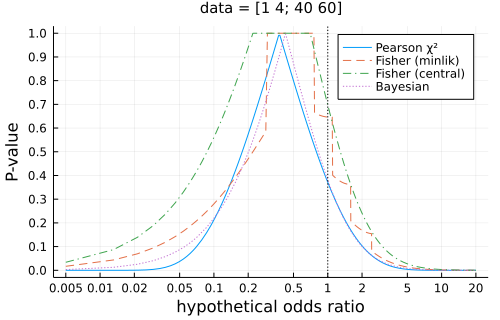

In [12]:
@show odds_ratio_of_data = a*d/(b*c)
@show pvalue_or_pearson_chisq(a, b, c, d; ω=1)
@show pvalue_or_sterne(a, b, c, d; ω=1)
@show pvalue_or_clopper_pearson(a, b, c, d; ω=1)
@show pvalue_or_bayes(1)

xlim = (0.005, 20)
P = plot()
plot!(ω -> pvalue_or_pearson_chisq(a, b, c, d; ω), xlim...; label="Pearson χ²")
plot!(ω -> pvalue_or_sterne(a, b, c, d; ω), xlim...; label="Fisher (minlik)", ls=:dash)
plot!(ω -> pvalue_or_clopper_pearson(a, b, c, d; ω), xlim...; label="Fisher (central)", ls=:dashdot)
plot!(ω -> pvalue_or_bayes(ω), xlim...; label="Bayesian", ls=:dot)
vline!([1]; label="", ls=:dot, c=:black)
plot!(; xscale=:log10, xtick=logtick(; xlim), ytick=0:0.1:1)
plot!(; xguide="hypothetical odds ratio", yguide="P-value")
title!("data = $([a b; c d])")

odds_ratio_of_data = (a * d) / (b * c) = 0.375
pvalue_or_pearson_chisq(a, b, c, d; ω = 1) = 0.37100223163381263
pvalue_or_sterne(a, b, c, d; ω = 1) = 0.6461862941554887
pvalue_or_clopper_pearson(a, b, c, d; ω = 1) = 0.6974876286556744
pvalue_or_bayes(1) = 0.380412


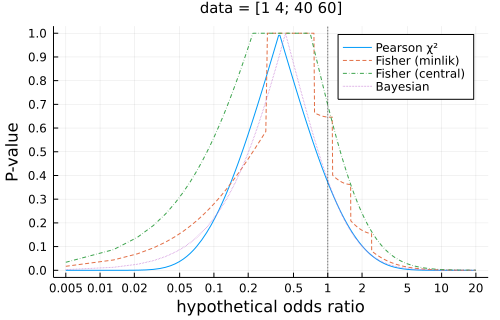

In [13]:
@show odds_ratio_of_data = a*d/(b*c)
@show pvalue_or_pearson_chisq(a, b, c, d; ω=1)
@show pvalue_or_sterne(a, b, c, d; ω=1)
@show pvalue_or_clopper_pearson(a, b, c, d; ω=1)
@show pvalue_or_bayes(1)
plot(P; fmt=:svg)

risk_ratio_of_data = (a * (c + d)) / ((a + b) * c) = 0.5
pvalue_rr_pearson_chisq(a, b, c, d; ρ = 1) = 0.3710022316338125
pvalue_rr_bayes(1) = 0.380412


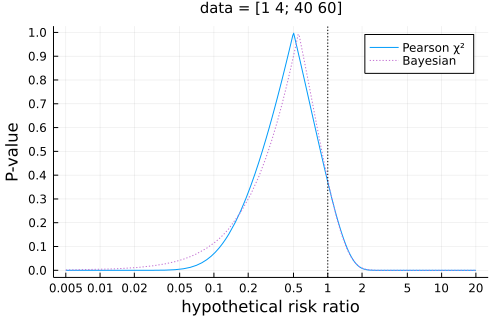

In [14]:
@show risk_ratio_of_data = a*(c+d)/((a+b)*c)
@show pvalue_rr_pearson_chisq(a, b, c, d; ρ=1)
@show pvalue_rr_bayes(1)

xlim = (0.005, 20)
Q = plot()
plot!(ρ -> pvalue_rr_pearson_chisq(a, b, c, d; ρ), xlim...; label="Pearson χ²")
plot!(ρ -> pvalue_rr_bayes(ρ), xlim...; label="Bayesian", ls=:dot, c=4)
vline!([1]; label="", ls=:dot, c=:black)
plot!(; xscale=:log10, xtick=logtick(; xlim), ytick=0:0.1:1)
plot!(; xguide="hypothetical risk ratio", yguide="P-value")
title!("data = $([a b; c d])")

risk_ratio_of_data = (a * (c + d)) / ((a + b) * c) = 0.5
pvalue_rr_pearson_chisq(a, b, c, d; ρ = 1) = 0.3710022316338125
pvalue_rr_bayes(1) = 0.380412


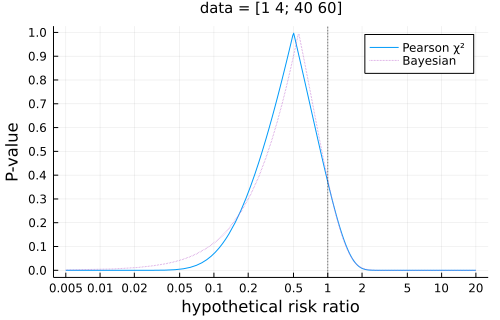

In [15]:
@show risk_ratio_of_data = a*(c+d)/((a+b)*c)
@show pvalue_rr_pearson_chisq(a, b, c, d; ρ=1)
@show pvalue_rr_bayes(1)
plot(Q; fmt=:svg)

In [16]:
ecdf_rr = pvalue_rr_bayes.ecdf_rr
ecdf_rr(1)

0.809794

In [17]:
a, b, c, d = 1, 4, 40, 60

(; pvalue_or_bayes, pvalue_rr_bayes) =
    make_pvalue_functions_bayes(a, b, c, d; conjprior=(1, 1))

(pvalue_or_bayes = pvalue_or_bayes, pvalue_rr_bayes = pvalue_rr_bayes, confint_or_bayes = var"#confint_or_bayes#22"{ECDF{Vector{Float64}, Weights{Float64, Float64, Vector{Float64}}}}(ECDF{Vector{Float64}, Weights{Float64, Float64, Vector{Float64}}}([0.0002994476453545416, 0.0003330918715709091, 0.0004784652449892791, 0.0005143623251253072, 0.0005740536763066844, 0.000814007166184491, 0.0008560543028223117, 0.0008838475593252626, 0.000948774564604062, 0.0010542794357816067  …  22.803708265697633, 22.86432546563113, 23.33067359102897, 23.403423942876046, 24.055240362304843, 26.29742353329007, 28.044056867842404, 29.64002185269803, 32.29043099252266, 43.7982327316337], Float64[])), confint_rr_bayes = var"#confint_rr_bayes#23"{ECDF{Vector{Float64}, Weights{Float64, Float64, Vector{Float64}}}}(ECDF{Vector{Float64}, Weights{Float64, Float64, Vector{Float64}}}([0.0005283546223462338, 0.0005312530997121086, 0.0007666984427404173, 0.0009277544241750468, 0.0009773702082710024, 0.0012260266402390

odds_ratio_of_data = (a * d) / (b * c) = 0.375
pvalue_or_pearson_chisq(a, b, c, d; ω = 1) = 0.37100223163381263
pvalue_or_sterne(a, b, c, d; ω = 1) = 0.6461862941554887
pvalue_or_clopper_pearson(a, b, c, d; ω = 1) = 0.6974876286556744
pvalue_or_bayes(1) = 0.47665599999999997


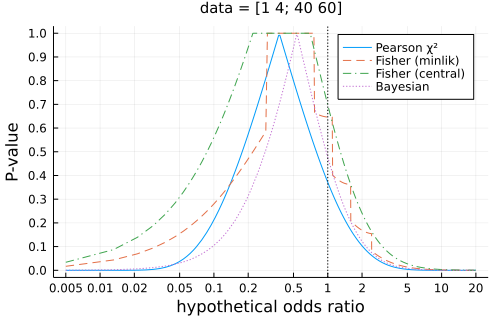

In [18]:
@show odds_ratio_of_data = a*d/(b*c)
@show pvalue_or_pearson_chisq(a, b, c, d; ω=1)
@show pvalue_or_sterne(a, b, c, d; ω=1)
@show pvalue_or_clopper_pearson(a, b, c, d; ω=1)
@show pvalue_or_bayes(1)

xlim = (0.005, 20)
P = plot()
plot!(ω -> pvalue_or_pearson_chisq(a, b, c, d; ω), xlim...; label="Pearson χ²")
plot!(ω -> pvalue_or_sterne(a, b, c, d; ω), xlim...; label="Fisher (minlik)", ls=:dash)
plot!(ω -> pvalue_or_clopper_pearson(a, b, c, d; ω), xlim...; label="Fisher (central)", ls=:dashdot)
plot!(ω -> pvalue_or_bayes(ω), xlim...; label="Bayesian", ls=:dot)
vline!([1]; label="", ls=:dot, c=:black)
plot!(; xscale=:log10, xtick=logtick(; xlim), ytick=0:0.1:1)
plot!(; xguide="hypothetical odds ratio", yguide="P-value")
title!("data = $([a b; c d])")

odds_ratio_of_data = (a * d) / (b * c) = 0.375
pvalue_or_pearson_chisq(a, b, c, d; ω = 1) = 0.37100223163381263
pvalue_or_sterne(a, b, c, d; ω = 1) = 0.6461862941554887
pvalue_or_clopper_pearson(a, b, c, d; ω = 1) = 0.6974876286556744
pvalue_or_bayes(1) = 0.47665599999999997


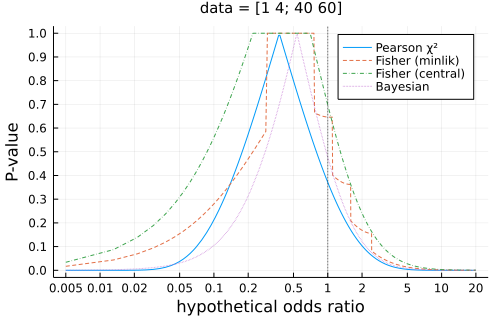

In [19]:
@show odds_ratio_of_data = a*d/(b*c)
@show pvalue_or_pearson_chisq(a, b, c, d; ω=1)
@show pvalue_or_sterne(a, b, c, d; ω=1)
@show pvalue_or_clopper_pearson(a, b, c, d; ω=1)
@show pvalue_or_bayes(1)
plot(P; fmt=:svg)

risk_ratio_of_data = (a * (c + d)) / ((a + b) * c) = 0.5
pvalue_rr_pearson_chisq(a, b, c, d; ρ = 1) = 0.3710022316338125
pvalue_rr_bayes(1) = 0.47665599999999997


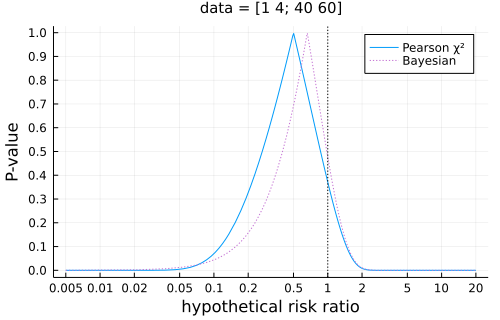

In [20]:
@show risk_ratio_of_data = a*(c+d)/((a+b)*c)
@show pvalue_rr_pearson_chisq(a, b, c, d; ρ=1)
@show pvalue_rr_bayes(1)

xlim = (0.005, 20)
Q = plot()
plot!(ρ -> pvalue_rr_pearson_chisq(a, b, c, d; ρ), xlim...; label="Pearson χ²")
plot!(ρ -> pvalue_rr_bayes(ρ), xlim...; label="Bayesian", ls=:dot, c=4)
vline!([1]; label="", ls=:dot, c=:black)
plot!(; xscale=:log10, xtick=logtick(; xlim), ytick=0:0.1:1)
plot!(; xguide="hypothetical risk ratio", yguide="P-value")
title!("data = $([a b; c d])")

risk_ratio_of_data = (a * (c + d)) / ((a + b) * c) = 0.5
pvalue_rr_pearson_chisq(a, b, c, d; ρ = 1) = 0.3710022316338125
pvalue_rr_bayes(1) = 0.47665599999999997


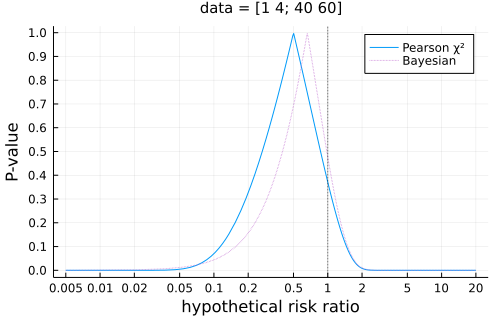

In [21]:
@show risk_ratio_of_data = a*(c+d)/((a+b)*c)
@show pvalue_rr_pearson_chisq(a, b, c, d; ρ=1)
@show pvalue_rr_bayes(1)
plot(Q; fmt=:svg)

In [22]:
ecdf_rr = pvalue_rr_bayes.ecdf_rr
ecdf_rr(1)

0.761672

In [23]:
function pdfRR(beta1, beta2, ρ)
    f(q) = exp(logpdf(beta1, ρ*q) + log(q) + logpdf(beta2, q)) 
    if 0 < ρ ≤ 1
        quadgk(f, 0, 1)[1]
    elseif ρ > 1
        quadgk(f, 0, 1/ρ)[1]
    else
        zero(ρ)
    end
end

function cdfRR(beta1, beta2, ρ)
    if 0 < ρ ≤ 1
        f(p) = exp(logpdf(beta1, p) + logccdf(beta2, p/ρ))
        quadgk(f, 0, ρ)[1]
    elseif ρ > 1
        g(q) = exp(logpdf(beta2, q) + logccdf(beta1, ρ*q))
        1 - quadgk(g, 0, 1/ρ)[1]
    else
        zero(ρ)
    end
end

cdfRR (generic function with 1 method)

In [24]:
cdfRR(Beta(2, 5), Beta(41, 61), 1)

0.762337686271621

In [25]:
cdfRR(Beta(1.5, 4.5), Beta(40.5, 60.5), 1)

0.8100417212731605

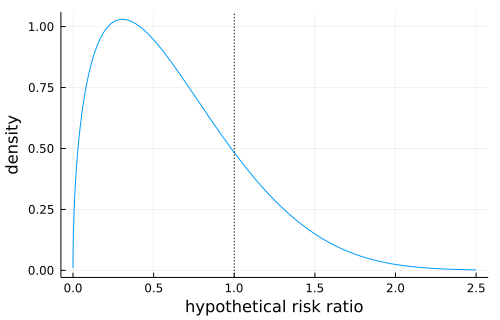

In [26]:
xlim = (1e-5, 2.5)
plot(ρ -> pdfRR(Beta(1.5, 4.5), Beta(40.5, 60.5), ρ), xlim...; label="")
vline!([1]; label="", ls=:dot, c=:black)
plot!(; xguide="hypothetical risk ratio", yguide="density")

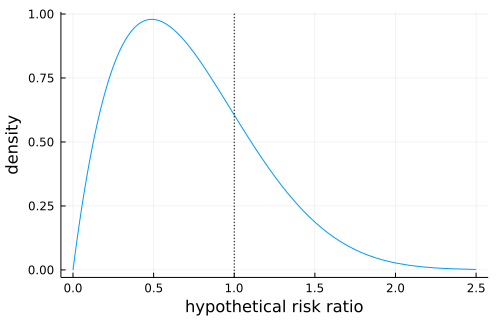

In [27]:
xlim = (1e-5, 2.5)
plot(ρ -> pdfRR(Beta(2, 5), Beta(41, 61), ρ), xlim...; label="")
vline!([1]; label="", ls=:dot, c=:black)
plot!(; xguide="hypothetical risk ratio", yguide="density")

In [28]:
function plot_probability_of_type_I_error(m, n, p, q=p)
    A = rand(Binomial(m, p), 10^5)
    B = @. 5 - A
    C = rand(Binomial(n, p), 10^5)
    D = @. 100 - C
    pval_pearson_chisq = pvalue_or_pearson_chisq.(A, B, C, D)
    pval_fisher = pvalue_or_sterne.(A, B, C, D)

    ecdf_F = ecdf(pval_pearson_chisq)
    ecdf_G = ecdf(pval_fisher)
    F(x) = ecdf_F(x)
    G(x) = ecdf_G(x)
    plot(; legend=:topleft)
    plot!(F, 0, 0.1; label="Pearson χ²")
    plot!(G, 0, 0.1; label="Fisher (minlik)")
    plot!(; xtick=0:0.01:1, ytick=0:0.01:1)
    plot!(identity, 0, 0.1; label="", ls=:dot, c=:black)
    plot!(; size=(400, 400))
    plot!(; xguide="significance level", yguide="probability of type I error")
    title!("Binomial($m, $p)×Binomial($n, $p))")
end

plot_probability_of_type_I_error (generic function with 2 methods)

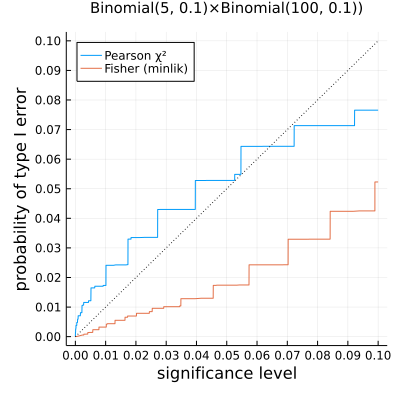

In [29]:
plot_probability_of_type_I_error(5, 100, 0.1)

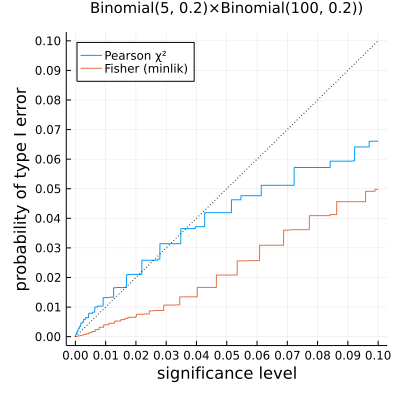

In [30]:
plot_probability_of_type_I_error(5, 100, 0.2)

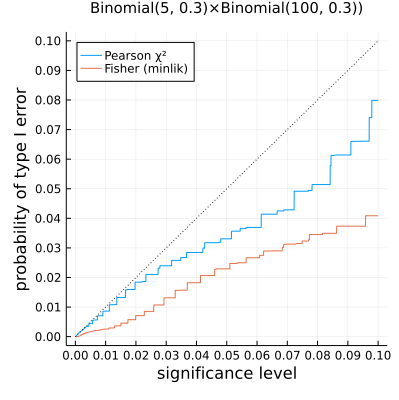

In [31]:
plot_probability_of_type_I_error(5, 100, 0.3)

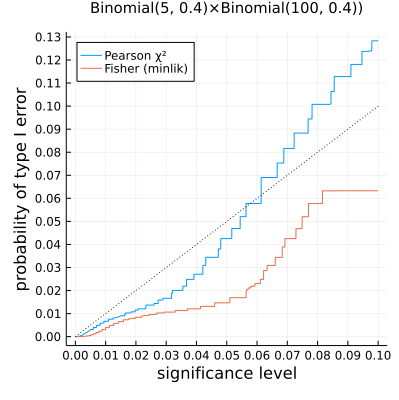

In [32]:
plot_probability_of_type_I_error(5, 100, 0.4)

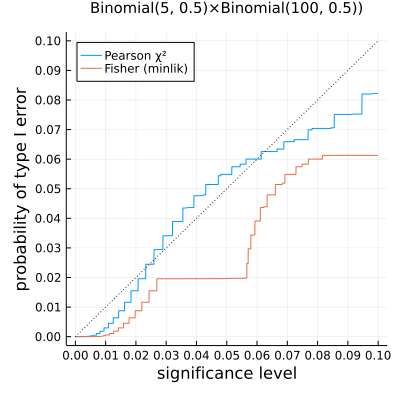

In [33]:
plot_probability_of_type_I_error(5, 100, 0.5)

In [34]:
function plot_posteriors(a=4, b=1, c=60, d=40;
        γ = 0.5, δ = 0.5,
        xlim = confint_rr_pearson_chisq(a, b, c, d; α=1e-6),
        textpos = (1.7, 0.8),
        show_annotation = true,
    )
    beta1 = Beta(a+γ, b+δ)
    beta2 = Beta(c+γ, d+δ)
    
    @show 1 - pvalue_rr_pearson_chisq(a, b, c, d)/2
    @show prob_of_first_winning = 1 - cdfRR(beta1, beta2, 1)
    println()
    @show pvalue_rr_pearson_chisq(a, b, c, d)
    @show 2(1 - prob_of_first_winning)

    P = plot(; legend=:topleft)
    plot!(beta1; label="p ∼ Beta$(params(beta1))")
    plot!(beta2; label="q ∼ Beta$(params(beta2))")
    plot!(; xguide="hypothetical success rate", yguide="density")
    plot!(; xtick=0:0.1:1)
    plot!(; leftmargin=4Plots.mm, bottommargin=4Plots.mm)

    Q = plot()
    plot!(ρ -> pdfRR(beta1, beta2, ρ), 1, last(xlim); label="")
    plot!(ρ -> pdfRR(beta1, beta2, ρ), first(xlim), 1; label="")
    vline!([1]; label="", ls=:dot, c=:black)
    plot!(; xguide="hypothetical success rate ratio p/q", yguide="density")
    show_annotation && annotate!(textpos..., text("$(100round(prob_of_first_winning; digits=3))%", 12, :left, :blue))

    plot(P, Q; size=(800, 250))
end

plot_posteriors (generic function with 5 methods)

1 - pvalue_rr_pearson_chisq(a, b, c, d) / 2 = 0.8144988841830938
prob_of_first_winning = 1 - cdfRR(beta1, beta2, 1) = 0.8100417210617243

pvalue_rr_pearson_chisq(a, b, c, d) = 0.3710022316338125
2 * (1 - prob_of_first_winning) = 0.3799165578765513


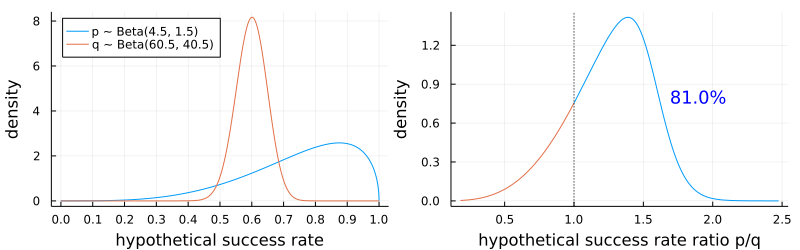

In [35]:
plot_posteriors()

1 - pvalue_rr_pearson_chisq(a, b, c, d) / 2 = 0.8144988841830938
prob_of_first_winning = 1 - cdfRR(beta1, beta2, 1) = 0.7623376862716229

pvalue_rr_pearson_chisq(a, b, c, d) = 0.3710022316338125
2 * (1 - prob_of_first_winning) = 0.4753246274567542


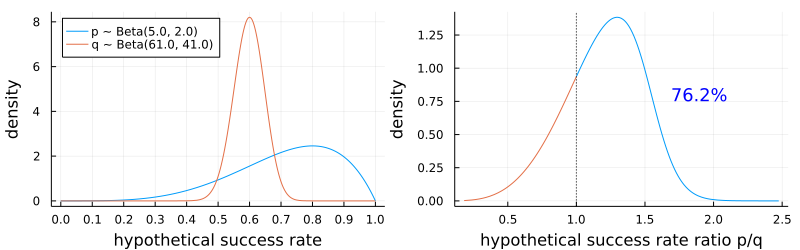

In [36]:
plot_posteriors(γ=1, δ=1)

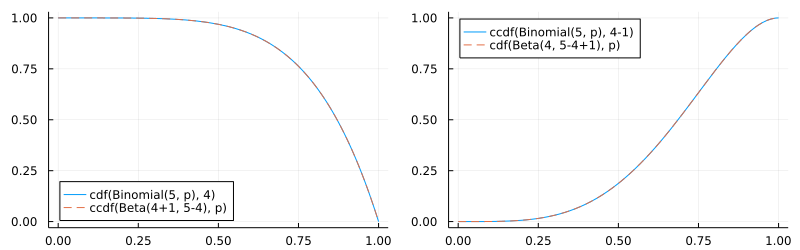

In [37]:
P = plot(; legend=:bottomleft)
plot!(p -> cdf(Binomial(5, p), 4), 0, 1; label="cdf(Binomial(5, p), 4)")
plot!(p -> ccdf(Beta(4+1, 5-4), p); ls=:dash, label="ccdf(Beta(4+1, 5-4), p)")

Q = plot(; legend=:topleft)
plot!(p -> ccdf(Binomial(5, p), 4-1), 0, 1; label="ccdf(Binomial(5, p), 4-1)")
plot!(p -> cdf(Beta(4, 5-4+1), p); ls=:dash, label="cdf(Beta(4, 5-4+1), p)")

plot(P, Q; size=(800, 250))

In [38]:
function plot_pvalues(a=4, b=1, c=60, d=40;
        γ = 0.5, δ = 0.5,
        xlim = confint_rr_pearson_chisq(a, b, c, d; α=1e-6),
        plot_confint = false,
        α = 0.05,
    )
    beta1 = Beta(a+γ, b+δ)
    beta2 = Beta(c+γ, d+δ)
    
    pvalue_beta1(p) = min(1, 2cdf(beta1, p), 2ccdf(beta1, p))
    pvalue_beta2(p) = min(1, 2cdf(beta2, p), 2ccdf(beta2, p))
    pvalue_rr_bayes(ρ) = min(1, 2cdfRR(beta1, beta2, ρ), 2(1-cdfRR(beta1, beta2, ρ)))
    confint_rr_bayes(α) = find_zeros(ρ -> pvalue_rr_bayes(ρ)-α, xlim...)
    ci_rr_bayes = confint_rr_bayes(α)
    ci_rr_pearson_chisq = confint_rr_pearson_chisq(a, b, c, d; α)
    
    P = plot(; legend=:topleft)
    plot!(p -> pvalue_beta1(p), 0, 1; label="p ∼ Beta$(params(beta1))", c=1)
    plot!(q -> pvalue_beta2(q), 0, 1; label="q ∼ Beta$(params(beta2))", c=2)
    plot!(p -> pvalue_wilson(a+b, a, p), 0, 1; label="Wilson ($a, $b)", c=:blue, ls=:dash)
    plot!(p -> pvalue_wilson(c+d, c, p), 0, 1; label="Wilson ($c, $d)", c=:red, ls=:dash)
    plot!(; xguide="hypothetical success rate", yguide="P-value")
    plot!(; xtick=0:0.1:1)
    plot!(; leftmargin=4Plots.mm, bottommargin=4Plots.mm)

    Q = plot(legend=:topright)
    plot_confint && hline!([α]; label="", c=:black, ls=:dot)
    plot!(ρ -> pvalue_rr_bayes(ρ), 1, last(xlim); label="", c=1)
    plot!(ρ -> pvalue_rr_bayes(ρ), first(xlim), 1; label="", c=2)
    plot_confint && plot!(ci_rr_bayes, fill(α+0.005, 2); label="$(100(1-α))% BCI", c=:blue, lw=1.5)
    plot!(ρ -> pvalue_rr_pearson_chisq(a, b, c, d; ρ), 1, last(xlim); label="", c=:blue, ls=:dash)
    plot!(ρ -> pvalue_rr_pearson_chisq(a, b, c, d; ρ), first(xlim), 1; label="", c=:red, ls=:dash)
    plot_confint && plot!(ci_rr_pearson_chisq, fill(α-0.005, 2); label="$(100(1-α))% CI", c=:red, lw=1.5)
    vline!([1]; label="", ls=:dot, c=:black)
    plot!(; xguide="hypothetical success rate ratio p/q", yguide="P-value")
    plot!(; ytick=0:0.1:1)

    plot(P, Q; size=(800, 250))
end

plot_pvalues (generic function with 5 methods)

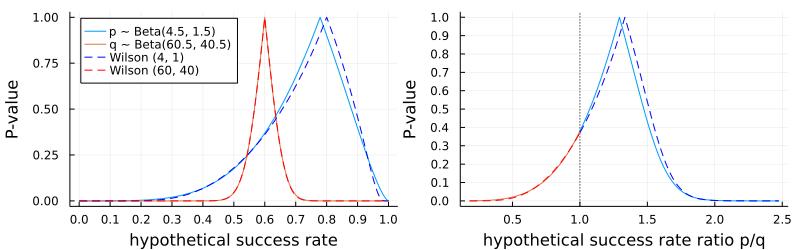

In [39]:
plot_pvalues()

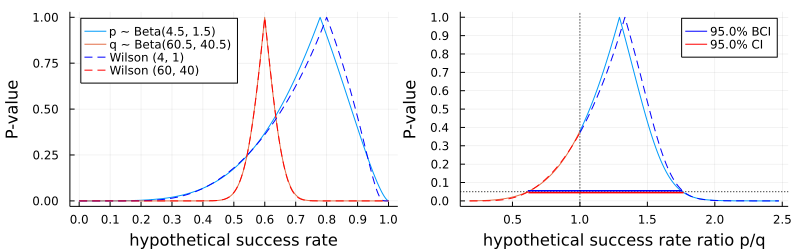

In [40]:
plot_pvalues(plot_confint=true)

1 - pvalue_rr_pearson_chisq(a, b, c, d) / 2 = 0.8144988841830938
prob_of_first_winning = 1 - cdfRR(beta1, beta2, 1) = 0.8100417210617243

pvalue_rr_pearson_chisq(a, b, c, d) = 0.3710022316338125
2 * (1 - prob_of_first_winning) = 0.3799165578765513


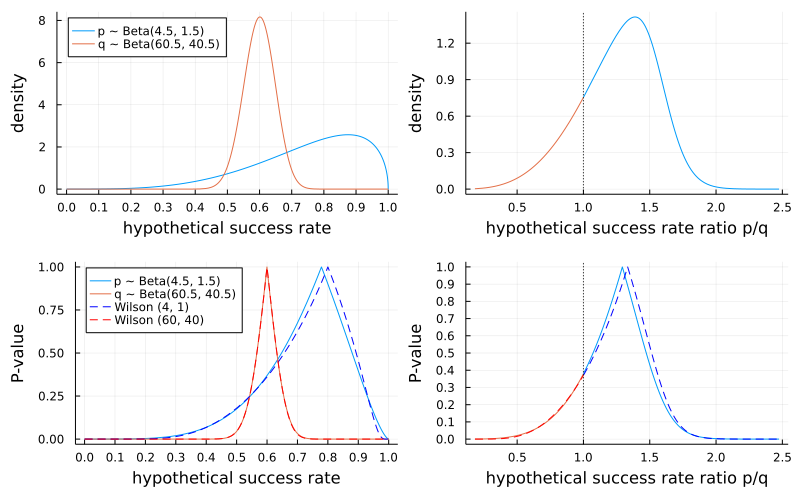

In [41]:
plot(plot_posteriors(show_annotation=false),
    plot_pvalues();
    size=(800, 500), layout=(2,1))

1 - pvalue_rr_pearson_chisq(a, b, c, d) / 2 = 0.8144988841830938
prob_of_first_winning = 1 - cdfRR(beta1, beta2, 1) = 0.8100417210617243

pvalue_rr_pearson_chisq(a, b, c, d) = 0.3710022316338125
2 * (1 - prob_of_first_winning) = 0.3799165578765513


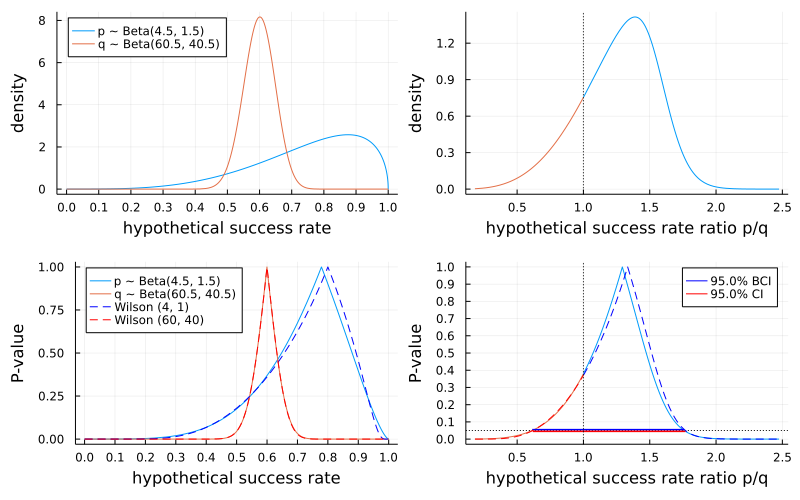

In [42]:
plot(plot_posteriors(show_annotation=false),
    plot_pvalues(plot_confint=true);
    size=(800, 500), layout=(2,1))

1 - pvalue_rr_pearson_chisq(a, b, c, d) / 2 = 0.8144988841830938
prob_of_first_winning = 1 - cdfRR(beta1, beta2, 1) = 0.7623376862716229

pvalue_rr_pearson_chisq(a, b, c, d) = 0.3710022316338125
2 * (1 - prob_of_first_winning) = 0.4753246274567542


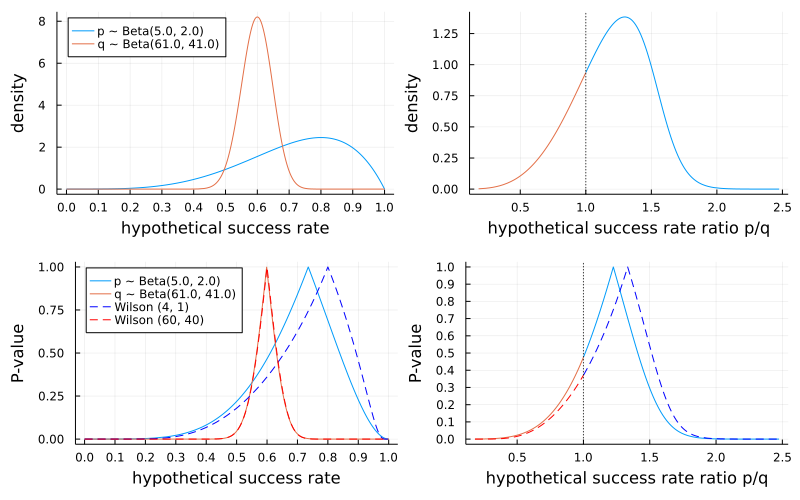

In [43]:
plot(plot_posteriors(γ=1, δ=1, show_annotation=false),
    plot_pvalues(γ=1, δ=1);
    size=(800, 500), layout=(2,1))

1 - pvalue_rr_pearson_chisq(a, b, c, d) / 2 = 0.8144988841830938
prob_of_first_winning = 1 - cdfRR(beta1, beta2, 1) = 0.7623376862716229

pvalue_rr_pearson_chisq(a, b, c, d) = 0.3710022316338125
2 * (1 - prob_of_first_winning) = 0.4753246274567542


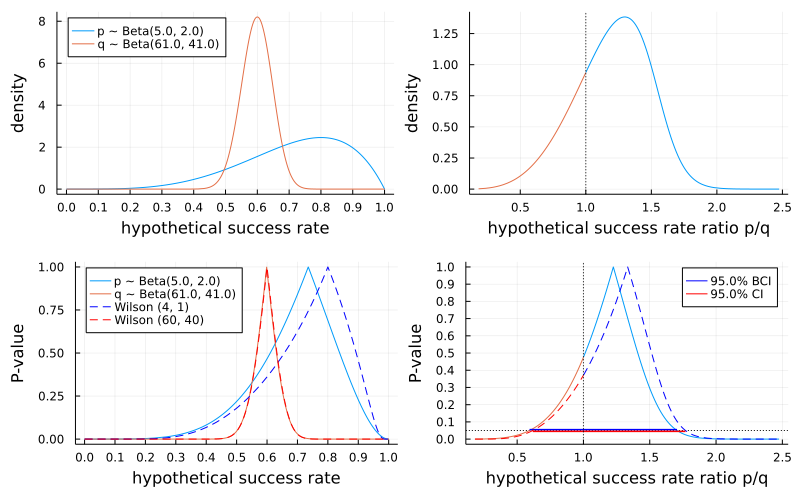

In [44]:
plot(plot_posteriors(γ=1, δ=1, show_annotation=false),
    plot_pvalues(γ=1, δ=1, plot_confint=true);
    size=(800, 500), layout=(2,1))